197878.0


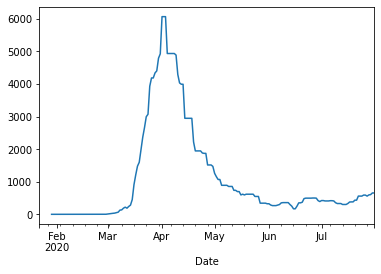

In [4]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv("time-series-19-covid-combined.csv", index_col='Date', parse_dates=True, dayfirst=False) 
# Preview the first 5 lines of the loaded data 
#data = data[data['Country/Region']=='Italy']
data = data[data['Country/Region']=='Germany']
#data = data[data['Country/Region']=='US']
data['CM10']=data['Confirmed'].shift(10)
data['cfr']=100*data['Deaths']/data['Confirmed']
data['cfr10']=100*data['Deaths']/data['CM10']
data['ineu']=data['Confirmed'].diff(1)
data['ineu10']=data['CM10'].diff(1)
data['mki']=0.06*data['ineu']
data['dneu']=data['Deaths'].diff(1)

# Infektionsrate ist: wieviele wurden heute gegenüber der letzten Zeit neu infiziert
# berechne ich mal mit Mittelwert gestern und heute im Verhältnis zu Mittelwert der 
# letzten drei Tage (gestern vorgestern und vorvorgestern)
data['avg_new_2d']=data['ineu'].rolling(2).mean()
data['avg_new_l3d']=data['ineu'].shift(1).rolling(5).mean()
data['infection_rate']=data['avg_new_2d']/data['avg_new_l3d']

#data['cfr']=100*data['dneu']/data['ineu']
#data['cfr10']=100*data['dneu']/data['ineu10']
# data.head()
#d = data[['cfr','cfr10']]
#d = data['infection_rate']
d = data['ineu'].rolling(7).median()
#d = data['Deaths'].diff(1).rolling(7).median()
print(d.sum())
plt.figure()
p = d.plot()
#p.set_yscale('log')
#p.set_ylim(0,20)

#d.plot(kind='bar')
#print(data['ineu'].sum()*0.06)